# Data analysis and dataset creation

## Libraries import

In [15]:
import argparse
import datetime
import random
import scipy
import glob
import time
import h5py
import os

import numpy as np
from pathlib import Path
from math import sqrt,exp,pi
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from sklearn.model_selection import train_test_split

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

import tensorflow_probability as tfp
tfd = tfp.distributions

from DnCNN import DnCNN
from utils import show_coils, reconstruct_from_kspace, reconstruct_magnitude_image, SNR, reconstruct_normalized_image, min_max_norm

In [16]:
# Listing available GPUs

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [17]:
# Setting up mixed precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


## Hyperparameters setting

In [18]:
# Data path
data_path = '/multicoil_val/'
VAL_SPLIT = 0.20
TEST_SPLIT = 0.40

# Setting options for the tf.data.Dataset
options = tf.data.Options()
options.experimental_optimization.noop_elimination = True # eliminate no-op transformations
options.experimental_optimization.apply_default_optimizations = False # do not apply default graph optimizations
options.experimental_optimization.autotune_buffers=True 
options.experimental_optimization.map_fusion=True # fuse map transformations
options.experimental_optimization.parallel_batch = True # parallelize copying of batch elements

# Preprocessing options
COIL_HEIGHT = 220
COIL_WIDTH = 114
AUGMENTATION = True

# Datasets dimension for subsampling
SUB_SAMPLE = True
TRAIN_SIZE = 350
VAL_SIZE = 80
TEST_SIZE = 80
BATCH_SIZE = 64

# Parameters for data selection
SLICE_RATIO = 2/3
NUM_COILS = 8

# Parameters for image corruption
BLIND_MODE = 1 #da 10 a 16 * 1e-6
STD_MIN = 15 #* 10e-3
STD_MAX = 30 #* 10e-3
STD = 1.5 * 10e-3

## Preliminary dataset analysis

The dataset used in this project is FastMRI. In particular, the dataset made up of brain MRIs is used.
For memory reasons, we split the validation set of FastMRI brains in order to obtain both our training and validation datasets.
These datasets are made up of .h5 files, that contain both raw data in the k-space and the reconstructed magnitude image.
As test set we use the one provided by FastMRI, which does not contain the reconstructed magnitude image.

Dimension of FastMRI validation set: 1378

Attributes of the considered scan:
{'acquisition': 'AXT2', 'max': 0.0008722479354087238, 'norm': 0.2081202670140693, 'patient_id': '53b27bb88797ca722027d8a9700f301c46d4e60736f362072596544a670dcc12'}

Number of slices (k-space): 16
Number of coils (k-space): 16
Height (k-space): 768
Width (k-space): 396

Number of slices (reconstruction): 16
Height (reconstruction): 384
Width (reconstruction): 384


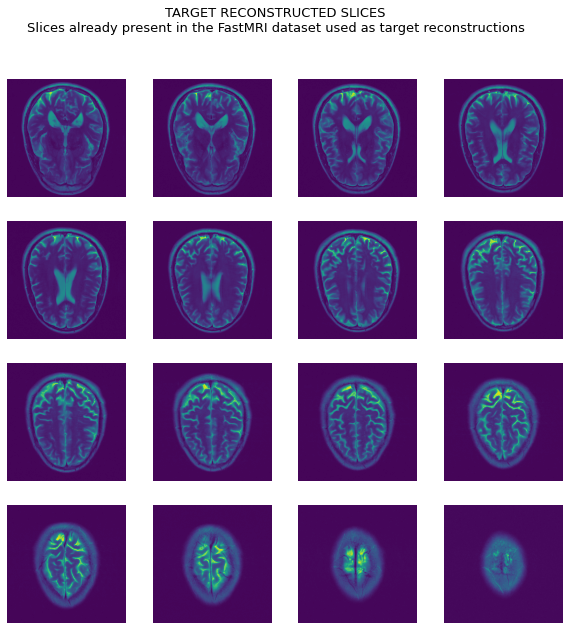

In [32]:
files = list(Path(data_path).iterdir())
print(f'Dimension of FastMRI validation set: {len(files)}\n')

# We take the first .h5 file in the dataset
fname = files[0]

with h5py.File(fname, "r") as hf:
    
    attrs = dict(hf.attrs)
    print(f'Attributes of the considered scan:\n{attrs}\n')
    
    num_slices = hf["kspace"].shape[0]
    num_coils = hf["kspace"].shape[1]
    height = hf["kspace"].shape[2]
    width = hf["kspace"].shape[3]
    
    print(f'Number of slices (k-space): {num_slices}')
    print(f'Number of coils (k-space): {num_coils}')
    print(f'Height (k-space): {height}')
    print(f'Width (k-space): {width}\n')
    
    num_slices = hf["reconstruction_rss"].shape[0]
    height = hf["reconstruction_rss"].shape[1]
    width = hf["reconstruction_rss"].shape[2]
    print(f'Number of slices (reconstruction): {num_slices}')
    print(f'Height (reconstruction): {height}')
    print(f'Width (reconstruction): {width}')
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle('TARGET RECONSTRUCTED SLICES\nSlices already present in the FastMRI dataset used as target reconstructions', fontsize=13)
    for i,slice in enumerate(hf["reconstruction_rss"][()]):
        plt.subplot(4, num_slices//4, i+1)
        plt.imshow(slice)
        plt.axis('off')
    
    kspaceslice = hf["kspace"][()][0]

Now, we will consider a single slice in order to show some important properties.

The shape of a single slice is: (16, 768, 396)
The first number represents the number of coils, while the other two 
dimensions represent the height and width of each coil.
In fact, the shape of a single coil is: (768, 396)



2022-02-18 11:53:21.860676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30967 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:0b:00.0, compute capability: 7.0


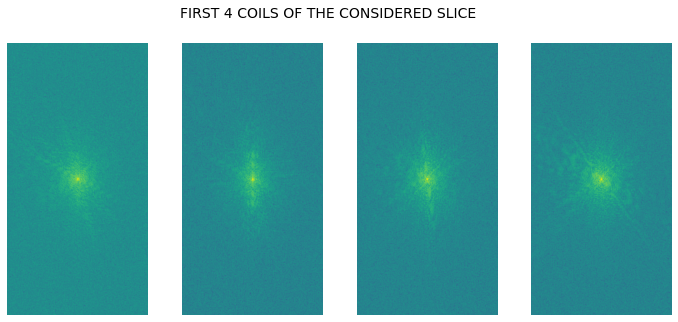

In [6]:
print(f'The shape of a single slice is: {kspaceslice.shape}')
print('The first number represents the number of coils, while the other two \ndimensions represent the height and width of each coil.')
print(f'In fact, the shape of a single coil is: {kspaceslice[0].shape}')


show_coils(kspaceslice, [0,1,2,3])

print()

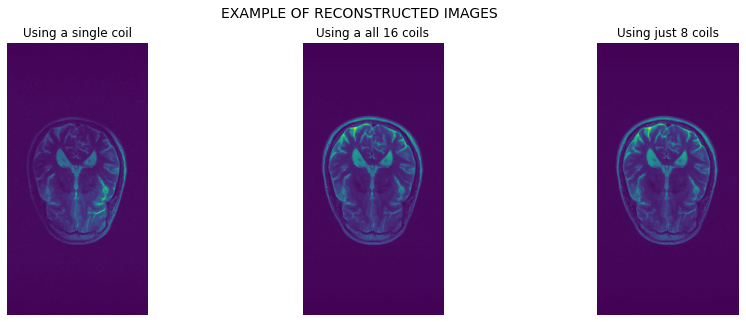

In [8]:
kspacecoil = kspaceslice[0]
reconstructed = reconstruct_from_kspace(kspacecoil)
kspaceslice_t = tf.transpose(kspaceslice, [1,2,0])
rec_image = reconstruct_magnitude_image(kspaceslice_t)
rec_image_8 = reconstruct_magnitude_image(kspaceslice_t[8:])

fig = plt.figure(figsize=(15,5))
fig.suptitle('EXAMPLE OF RECONSTRUCTED IMAGES\n', fontsize=14)

plt.subplot(1, 3, 1)
plt.title('Using a single coil')
plt.imshow(reconstructed)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(rec_image)
plt.title('Using a all 16 coils')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(rec_image_8)
plt.title('Using just 8 coils')
plt.axis('off')

print( )

In [9]:
slice_set = dict()
n_coils = dict()
progress_bar = tf.keras.utils.Progbar(len(files), interval=1)

for i,fname in enumerate(files):
    with h5py.File(fname, "r") as hf:

        kspaceslice = hf["kspace"][()][0]
        if kspaceslice.shape[0] in n_coils:
            n_coils[kspaceslice.shape[0]] += 1
        else:
            n_coils.update({kspaceslice.shape[0]: 1})
                
        kspaceslice = kspaceslice[0]
        if kspaceslice.shape in slice_set:
            slice_set[kspaceslice.shape] += 1
        else:
            slice_set.update({kspaceslice.shape: 1})
        progress_bar.update(i)

1374/1378 [============================>.] - ETA: 0s

In [10]:
print('Here we show the number of slices having a certain shape:\n')
print(slice_set)

print('\n\nNumber of slices having a specific number of coils :\n')
print(n_coils)

Here we show the number of slices having a certain shape:

{(768, 396): 419, (640, 320): 732, (768, 392): 51, (640, 322): 97, (512, 213): 3, (640, 260): 5, (640, 272): 27, (512, 276): 10, (640, 264): 15, (512, 214): 3, (512, 320): 2, (512, 234): 7, (640, 262): 1, (768, 324): 2, (640, 292): 2, (640, 240): 1, (768, 350): 1}


Number of slices having a specific number of coils :

{16: 412, 14: 89, 4: 427, 20: 347, 10: 3, 12: 70, 6: 13, 18: 5, 5: 10, 8: 2}


## Datasets creation

In [19]:
class generator:
    
    # This function returns the correlation matrix that expresses the correlation between
    # coils in the same slice and we consider a circular coils geometry such that:
    # - the correlation between first neighbors is 0.3
    # - the correlation between second neighbors is 0.15
    # - for all the others, the correlation is 0.05
    def generate_corr_matrix(self):
        num_coils = NUM_COILS
        
        C = np.eye(num_coils)
        for i in range(num_coils):
            for j in range(num_coils):
                distance = abs(i-j)
                if distance == 1 or distance == num_coils-1:
                    C[i][j] = 0.3
                elif distance == 2  or distance == num_coils-2:
                    C[i][j] = 0.15
                elif distance > 2:
                    C[i][j] = 0.05
        return C
    
    
    def compute_noise(self):
        
        std = STD
        if BLIND_MODE:
            std = (random.randint(STD_MIN,STD_MAX) * 1e-3)
            
        C = self.generate_corr_matrix()
        covariance = std**2 * C
        
        mvn = tfd.MultivariateNormalFullCovariance(loc=[0]*NUM_COILS, covariance_matrix=covariance)
        
        h = COIL_HEIGHT
        w = COIL_WIDTH
        
        noise = tf.concat([mvn.sample(sample_shape=([h,w])), mvn.sample(sample_shape=([h,w]))],axis=-1) # std*
        noise = tf.cast(noise, tf.float32)
        
        return noise        
        
    
    def corrupt_slice(self, slice_):

        h = slice_.shape[0]
        w = slice_.shape[1]

        noise = self.compute_noise()
        
        corrupted_slice = slice_ + noise

        slice_ = tf.image.per_image_standardization(slice_) #Linearly scales each image in image to have mean 0 and variance 1.
        corrupted_slice = tf.image.per_image_standardization(corrupted_slice)

        return slice_, corrupted_slice
    
    
    # This function agument the dataset by performing phase multiplication
    # on all the coils of a single slice: namely this is perfomed as
    # S(x,y) -> S(x,y) * exp{(i*theta)}
    # with S being the k-space signal and theta belonging to [0,2pi]
    def phase_multiplication(self, slice_):
        return tf.math.multiply(slice_, tf.math.exp(tf.complex(0.0,pi)))
    
    
    def augment_data(self, r, slice_):
        if r > 5 and r <= 7:
            aug_slice = self.phase_multiplication(slice_)
        
        elif r > 7 and r <= 8:
            aug_slice = tf.image.flip_left_right(slice_)
            
        else:
            aug_slice = tf.image.flip_up_down(slice_)
            
            if r > 9:
                aug_slice = tf.image.flip_left_right(aug_slice)
            
        return aug_slice

    
    # This function perform the preprocessing of the coils in a slice:
    # - normalize by the maximum value over the entire volume
    # - low-pass filter the frequency signal of the coil by reducing its size
    def preprocess_slice(self, coils, volume_max):
        
        normalized_slice = tf.stack([coil/tf.cast(tf.reduce_max(tf.math.abs(coil)),tf.complex64) for coil in tf.unstack(coils)])

        normalized_slice = tf.transpose(normalized_slice, [1, 2, 0])

        height, width = coils.shape[1], coils.shape[2]
            
        h_crop = (height-COIL_HEIGHT) // 2
        w_crop = (width-COIL_WIDTH) // 2
        cropped_slice = normalized_slice[h_crop:height-h_crop, w_crop:width-w_crop,:]
                            
        return cropped_slice
    
    
    def __call__(self, file, test):

        with h5py.File(file, 'r',rdcc_nbytes=500*1024**2) as hf:
            
            slices = hf['kspace'][()]
            n_slices = int(slices.shape[0] * SLICE_RATIO)
            slices = slices[:n_slices,:,:,:]
            
            volume_max = dict(hf.attrs)['max']

            for i,S in enumerate(slices):
                if S.shape[0] < NUM_COILS:
                    continue
                else:
                    if S.shape[0] < 12:
                        S = S[-NUM_COILS:,:,:]
                    elif S.shape[0]< 16:
                        S = S[[0,2,3,4,6,8,10,11],:,:]
                    elif S.shape[0] < 20:
                        S = S[[1,3,5,7,9,11,13,15],:,:]
                    else:
                        S = S[[1,4,6,9,11,14,16,19],:,:]
                        
                preprocessed_slice = self.preprocess_slice(S, volume_max)
                
                if AUGMENTATION and not test:
                    r = random.randint(0,10)
                    if r >= 5:
                        preprocessed_slice = self.augment_data(r, preprocessed_slice)

                real_slice = tf.concat([tf.math.real(preprocessed_slice), tf.math.imag(preprocessed_slice)],axis=-1)
                real_slice, corrupted_slice = self.corrupt_slice(real_slice)
                
                reconstructed_image = reconstruct_magnitude_image(real_slice, complex_flag=True) # 220,114
                
                yield reconstructed_image, real_slice, corrupted_slice

In [20]:
def split_data_files(data_path):
    # List of all .h5 files
    filenames_all = glob.glob(os.path.join(data_path, "*.h5"))
    
    # Train-val-test split
    filenames_train, filenames_val = train_test_split(filenames_all, test_size=VAL_SPLIT, random_state=42)
    filenames_val, filenames_test = train_test_split(filenames_val, test_size=TEST_SPLIT, random_state=42)
    
    # Eventually subsamples files
    if SUB_SAMPLE:
        random.seed(1)
        filenames_train = random.sample(filenames_train, TRAIN_SIZE)
        filenames_val = random.sample(filenames_val, VAL_SIZE)
        filenames_test = random.sample(filenames_val, TEST_SIZE)
        
    print ('Train size:',len(filenames_train))
    print ('Validation size:',len(filenames_val))
    print ('Test size:',len(filenames_test))
    
    return filenames_train, filenames_val, filenames_test

In [21]:
def create_dataset(filenames, test=False, val=False):
    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    
    if not test:
        dataset = dataset.with_options(options)
    
    AUTOTUNE = tf.data.AUTOTUNE
    gpu_transform = tf.data.experimental.prefetch_to_device('/gpu:0')
    
    if test:
        block_length = 1
    else:
        block_length = 167
    
    flag = False
    if test or val:
        flag = True
       
    dataset = dataset.interleave(lambda filename: tf.data.Dataset.from_generator(
                                generator(), 
                                output_signature=(
                                    tf.TensorSpec(shape=(220,114), dtype=tf.float32),
                                    tf.TensorSpec(shape=(220,114,16), dtype=tf.float32),
                                    tf.TensorSpec(shape=(220,114,16), dtype=tf.float32)),
                                args=(filename,flag)),
                                num_parallel_calls=AUTOTUNE,
                                cycle_length=1, block_length=block_length,deterministic=False)
    
    dataset = dataset.cache()
    
    if not test:
        dataset = dataset.shuffle(buffer_size=8192)
        dataset = dataset.batch(BATCH_SIZE)
        
    else:
        dataset = dataset.batch(1)
        
    dataset = dataset.apply(gpu_transform)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [22]:
train_filenames, val_filenames, test_filenames = split_data_files(data_path)

Train size: 350
Validation size: 80
Test size: 80


### Creating a new dataset

In [23]:
train_dataset = create_dataset(train_filenames)
val_dataset = create_dataset(val_filenames, val=True)
test_dataset = create_dataset(test_filenames, test=True)

We print the first sample from the first batch of the test set in order to see if the preprocessing is correct.

2022-04-03 19:06:05.652101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 153 of 8192
2022-04-03 19:06:15.654005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 329 of 8192
2022-04-03 19:06:25.568987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 512 of 8192
2022-04-03 19:06:35.724450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 693 of 8192
2022-04-03 19:06:45.679554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 860 of 8192
2022-04-03 19:06:55.583975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1013 of 8192
2022-04-03 19:07:05.607769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle 

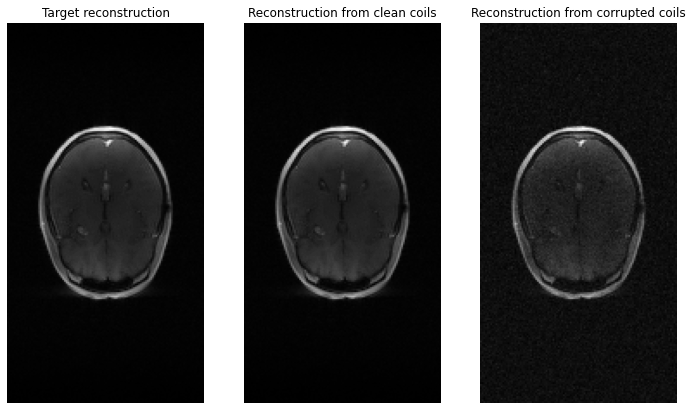

In [24]:
train_set = iter(train_dataset)

for rec, s, sn in train_set:
    recs = reconstruct_magnitude_image(s,batched=True,complex_flag=True)
    recsn = reconstruct_magnitude_image(sn,batched=True,complex_flag=True)
    
    fig = plt.figure(figsize=[12,10])
    plt.subplot(1,3,1)
    plt.imshow(rec[0],cmap='gray')
    plt.axis('off')
    plt.title('Target reconstruction')
    plt.subplot(1,3,2)
    plt.imshow(recs[0],cmap='gray')
    plt.axis('off')
    plt.title('Reconstruction from clean coils')
    plt.subplot(1,3,3)
    plt.imshow(recsn[0],cmap='gray')
    plt.axis('off')
    plt.title('Reconstruction from corrupted coils')
    break

In [26]:
psnrs = []
ssims = []
for target_rec, target_slice, corrupted_slice in test_dataset:
    normalized_target_rec = min_max_norm(tf.expand_dims(target_rec, axis=-1))
    normalized_noised_rec = reconstruct_normalized_image(corrupted_slice)

    psnr = tf.image.psnr(normalized_noised_rec, normalized_target_rec, 1)
    ssim = tf.image.ssim(normalized_noised_rec, normalized_target_rec, 1)
    
    ssims.append(ssim.numpy())
    psnrs.append(psnr.numpy())

print(f'The mean PSNR of the corrupted images in the test dataset is: {sum(psnrs)/len(psnrs)}')
print(f'The max PSNR of the corrupted images in the test dataset is: {max(psnrs)}')
print(f'The min PSNR of the corrupted images in the test dataset is: {min(psnrs)}\n')

print(f'The mean SSIM of the corrupted images in the test dataset is: {sum(ssims)/len(ssims)}')
print(f'The max SSIM of the corrupted images in the test dataset is: {max(ssims)}')
print(f'The min SSIM of the corrupted images in the test dataset is: {min(ssims)}')

The mean PSNR of the corrupted images in the test dataset is: [24.367048]
The max PSNR of the corrupted images in the test dataset is: [30.370234]
The min PSNR of the corrupted images in the test dataset is: [17.185637]

The mean SSIM of the corrupted images in the test dataset is: [0.45442623]
The max SSIM of the corrupted images in the test dataset is: [0.78728956]
The min SSIM of the corrupted images in the test dataset is: [0.2722548]


### Saving dataset

In [27]:
train_path = './data_comp_noblind_lownoise/train'
val_path = './data_comp_noblind_lownoise/val'
test_path = './data_comp_noblind_lownoise/test'

tf.data.experimental.save(train_dataset, train_path)
tf.data.experimental.save(val_dataset, val_path)
tf.data.experimental.save(test_dataset, test_path)

2022-04-03 19:09:03.737328: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-04-03 19:09:36.041288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 159 of 8192
2022-04-03 19:09:46.038157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 326 of 8192
2022-04-03 19:09:55.951410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-04-03 19:10:00.364129: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
